In [1]:
#Workbench imports
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.optimize import brentq

from workbench_version import * #load the model
from pathlib import Path

from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf

from ema_workbench import(ema_logging, perform_experiments)
from ema_workbench import MultiprocessingEvaluator

C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\urban-SETP\lib\site-packages\ema_workbench\em_framework\evaluators.py:21: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn(
C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\urban-SETP\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)
C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\urban-SETP\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "


# Run experiments

In [2]:
#### LOAD ADAPTATION STRATEGIES ####
from mayors import *
allMayors = [Reactive(),Economicus(),Sentiment(),Lawkeeper()]

In [3]:
# Load all SurgeHeight (Realisations of extreme value distribution)
transient_paths = list(Path('SurgeHeight','biased_from_five_hundred').glob('*.csv'))
print(len(transient_paths))

50


In [4]:
from ema_workbench import(RealParameter,ScalarOutcome, Constant, BooleanParameter, CategoricalParameter, IntegerParameter,
                          Model, TimeSeriesOutcome)

model = Model('Rotty',function=run_model_workbench)

model.uncertainties = [CategoricalParameter('SLR',categories=['01','02','03','04',
                                                              '05','06','07','08','09']),
                       #CategoricalParameter('SLR',categories=['01','03','06','09']),
                       CategoricalParameter('transient',categories =transient_paths), 
                       CategoricalParameter('Housing_market', #only for control of temp scalar outcome
                                            categories=['rational','boundedly_rational']),
                       CategoricalParameter('implementation_time', #only for small measure, large measure is calculated proportionally from it
                                categories=[4,5,6,7,8,9,10,11,12,13,14])]
                                
model.levers = [CategoricalParameter('Mayor',categories=allMayors)]

model.outcomes = [ScalarOutcome('HP_hp_2200'),
                  ScalarOutcome('CC_hp_2200'),
                  ScalarOutcome('HP_first_SETP'),
                  ScalarOutcome('CC_first_SETP'),]

In [5]:
#Determine the number of uncertainties and levers to completely sample all possibilities
number_of_uncertainties = 1
for unc in model.uncertainties:
    number_of_uncertainties *= len(unc._categories._data)
print(number_of_uncertainties)

9900


### Run without parallel processing

In [ ]:
experiments, outcomes = perform_experiments(models=model,scenarios=number_of_uncertainties,policies=4)
results = experiments, outcomes

### Run with parallel processing

In [7]:
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
     results = evaluator.perform_experiments(scenarios=number_of_uncertainties,policies=4)
experiments, outcomes = results

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 9900 scenarios * 4 policies * 1 model(s) = 39600 experiments
[MainProcess/INFO] 3960 cases completed
[MainProcess/INFO] 7920 cases completed
[MainProcess/INFO] 11880 cases completed
[MainProcess/INFO] 15840 cases completed
[MainProcess/INFO] 19800 cases completed
[MainProcess/INFO] 23760 cases completed
[MainProcess/INFO] 27720 cases completed
[MainProcess/INFO] 31680 cases completed
[MainProcess/INFO] 35640 cases completed
[MainProcess/INFO] 39600 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


### Save results

In [8]:
from ema_workbench import save_results

target = Path("temp","experiments")

today = datetime.date(datetime.now())
date = "{}_{}_{}".format(today.year,today.month,today.day)

if not target.exists(): target.mkdir()

save_results(results,Path(target,date + '_EMA_experiments_five_hundredTEST.tar.gz'))

[MainProcess/INFO] results saved successfully to D:\Python\Urban-SETP\temp\experiments\2021_2_19_EMA_experiments_five_hundredTEST.tar.gz


### Load results

In [23]:
from ema_workbench import load_results

target = Path("temp","experiments")
experiments, outcomes = load_results(target / "2020_10_23_EMA_experiments_five_hundred.tar.gz")

[MainProcess/INFO] results loaded succesfully from D:\Python\Urban-SETP\temp\experiments\2020_10_23_EMA_experiments_five_hundred.tar.gz


In [24]:
experiments.tail()

,Housing_market,SLR,implementation_time,transient,Mayor,scenario,policy,model
395995,rational,2,8,SurgeHeight\five_hundred\five_hundred_164.csv,R. Active,108895,7,Rotty
395996,boundedly_rational,3,7,SurgeHeight\five_hundred\five_hundred_130.csv,R. Active,108896,7,Rotty
395997,boundedly_rational,4,13,SurgeHeight\five_hundred\five_hundred_192.csv,R. Active,108897,7,Rotty
395998,boundedly_rational,9,9,SurgeHeight\five_hundred\five_hundred_142.csv,R. Active,108898,7,Rotty
395999,boundedly_rational,6,11,SurgeHeight\five_hundred\five_hundred_209.csv,R. Active,108899,7,Rotty


In [25]:
experiments2 = experiments.drop(['policy','model'],axis=1)
experiments2.head()

,Housing_market,SLR,implementation_time,transient,Mayor,scenario
0,rational,6,6,SurgeHeight\five_hundred\five_hundred_267.csv,Sentiment,9900
1,rational,6,8,SurgeHeight\five_hundred\five_hundred_196.csv,Sentiment,9901
2,rational,2,13,SurgeHeight\five_hundred\five_hundred_16.csv,Sentiment,9902
3,boundedly_rational,3,9,SurgeHeight\five_hundred\five_hundred_153.csv,Sentiment,9903
4,boundedly_rational,2,10,SurgeHeight\five_hundred\five_hundred_87.csv,Sentiment,9904


In [26]:
experiments3 = experiments2.copy()
map_house_market = {'rational' : 0, 
             'boundedly_rational' :1}
#map_mayor = {'H. Economicus': 0,
#             'Sentiment' : 1,
#             'R. Active' : 2,
#             'Lawkeeper' : 3}
map_mayor = {'H. Economicus': 1,
             'Sentiment' : 2,
             'R. Active' : 0,
             'Lawkeeper' : 3}

experiments3['Housing_market'].replace(map_house_market,inplace=True)
experiments3['Mayor'].replace(map_mayor,inplace=True)
experiments3['transient'] = experiments3['transient'].apply(lambda s : int(s.split('_')[-1].split('.')[0]))
experiments3[['Housing_market', 'SLR', 'transient', 'Mayor']].astype('float')
experiments3.head()

,Housing_market,SLR,implementation_time,transient,Mayor,scenario
0,0,6,6,267,2,9900
1,0,6,8,196,2,9901
2,0,2,13,16,2,9902
3,1,3,9,153,2,9903
4,1,2,10,87,2,9904


In [27]:
pd.DataFrame(outcomes)

,HP_hp_2200,CC_hp_2200,HP_first_SETP,CC_first_SETP
0,0,349603.388474,9999,9999
1,0,349603.388474,9999,9999
2,0,0.000000,9999,2101
3,0,348459.280872,2056,2115
4,0,227363.672293,2053,2096
...,...,...,...,...
395995,0,277261.757208,9999,2101
395996,0,347211.587672,2059,2089
395997,0,152563.671702,2032,2107
395998,287227,349858.775190,2085,9999


# Scenario discovery with first_SETP indicator

What is SD doing? It finds subspaces in the input space, where high concentrations of outcomes of interest are found. In our case: we search for points where the first SETP in the City Centre happens before the year 2200.

In [28]:
%matplotlib inline

from ema_workbench.analysis import prim
x = experiments3
y = outcomes['CC_first_SETP'] < 2200
prim_alg = prim.Prim(x,y,threshold=0.99)
box1 = prim_alg.find_box()

[MainProcess/INFO] 396000 points remaining, containing 85496 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.05259090909090909, coverage: 0.24359034340787872, density: 1.0 restricted_dimensions: 5


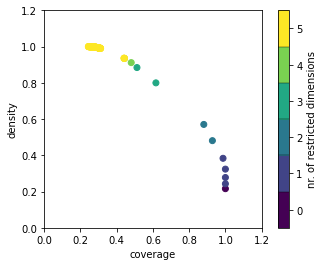

In [29]:
%matplotlib inline
box1.show_tradeoff()
plt.show()

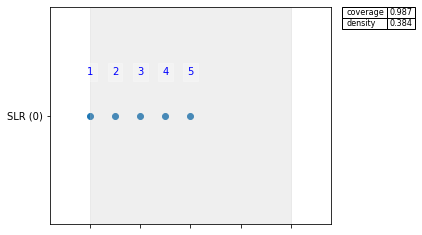

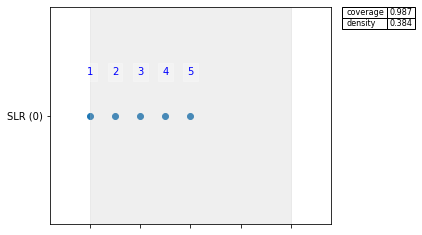

In [42]:
box1.inspect(4,style='graph')

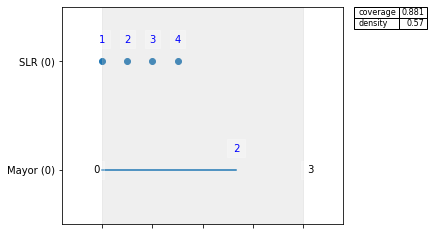

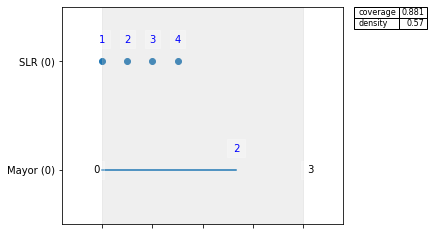

In [46]:
box1.inspect(6,style='graph')

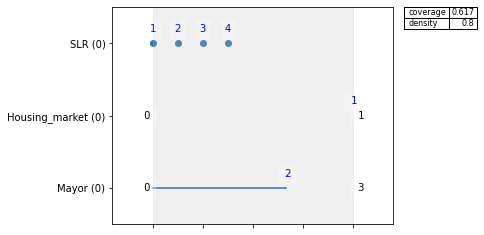

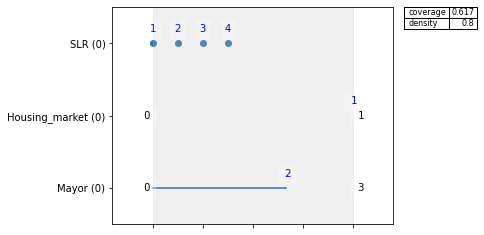

In [47]:
box1.inspect(7,style='graph')

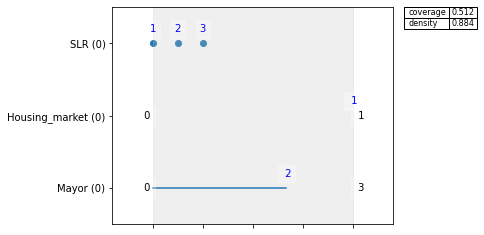

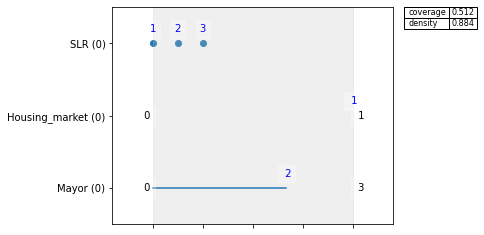

In [49]:
box1.inspect(8,style='graph')

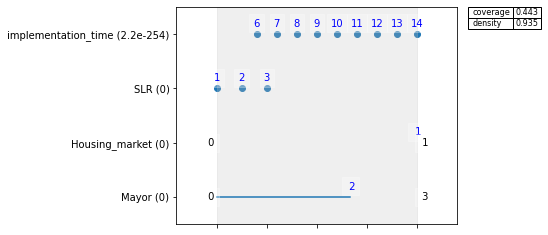

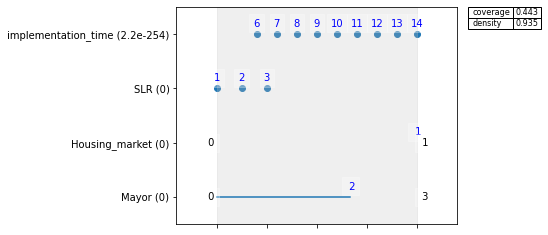

In [54]:
box1.inspect(10,style='graph')

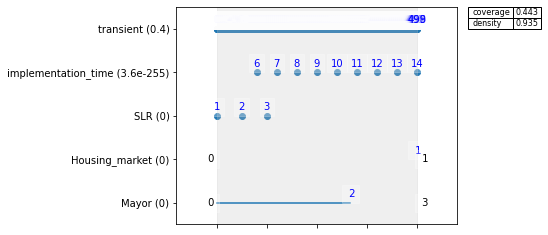

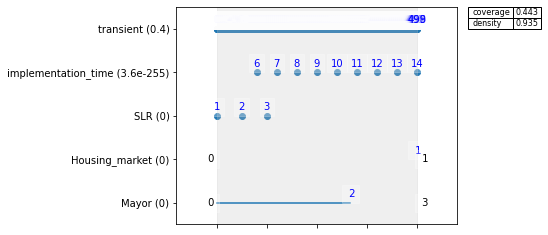

In [55]:
box1.inspect(11,style='graph')

In [61]:
box1.inspect(11)

coverage    0.442629
density      0.93488
id                11
mass         0.10222
mean         0.93488
res_dim            5
Name: 11, dtype: object

                                                                box 11  \
                                                                   min   
Mayor                                                                0   
Housing_market                                                       1   
SLR                                                          {1, 2, 3}   
implementation_time                   {6, 7, 8, 9, 10, 11, 12, 13, 14}   
transient            {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                                                        \
                                                                   max   
Mayor                                                                2   
Housing_market                                                       1   
SLR                               

Density = hoeveel procent van de punten in de box is een SETP?
Coverage = hoeveel procent van alle SETPs zit in de box?

### Feature scoring
Feature scoring is een soort gevoeligheidsanalyse. Die doe ik hier op 6 verschillend output indicatoren.

HP_hp_2200_obj : de huizenprijs in de Heijplaat, volgens een rationele huizenmarkt, in het jaar 2200

HP_hp_2200_sub : de huizenprijs in de Heijplaat, volgens een boundedly rational housing market, in het jaar 2200

CC__           : idem voor het stadscentrum

CC__           : idem voor het stadscentrum

HP_first_SETP  : Heijplaat: het jaartal waarin de eerste SETP plaatsvindt (nu alleen op basis van criterium 'rapid change')

CC_first_SETP  : City Centre: idem

In [62]:
experiments3

,Housing_market,SLR,implementation_time,transient,Mayor
0,0,6,6,267,2
1,0,6,8,196,2
2,0,2,13,16,2
3,1,3,9,153,2
4,1,2,10,87,2
...,...,...,...,...,...
395995,0,2,8,164,0
395996,1,3,7,130,0
395997,1,4,13,192,0
395998,1,9,9,142,0


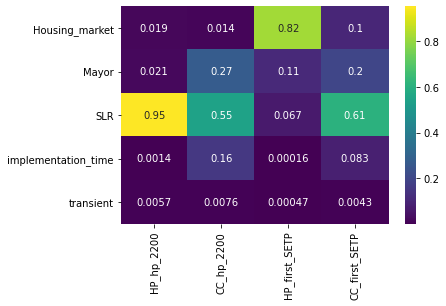

In [70]:
from ema_workbench.analysis import feature_scoring
x = experiments3
y = outcomes

fig, ax = plt.subplots(1,1)
fs = feature_scoring.get_feature_scores_all(x, y)
ax = sns.heatmap(fs, cmap='viridis', annot=True,ax=ax)

In [78]:
foldername = "Visualisations"

today = datetime.date(datetime.now())
date = "{}_{}_{}".format(today.year,today.month,today.day)

target = Path(foldername,date)

if not Path.exists(target): Path.mkdir(target)

fig.savefig((target / "Five_hundred_feature_scoring.png"),bbox_inches="tight",dpi=200)

### Dimensional stacking: 
This is a more visual approach to scenario discovery, indicating which combinations of input factors (X) explain outcome metrics of interest (M).

### What explains if SETPs in the City Centre occur before 2200?

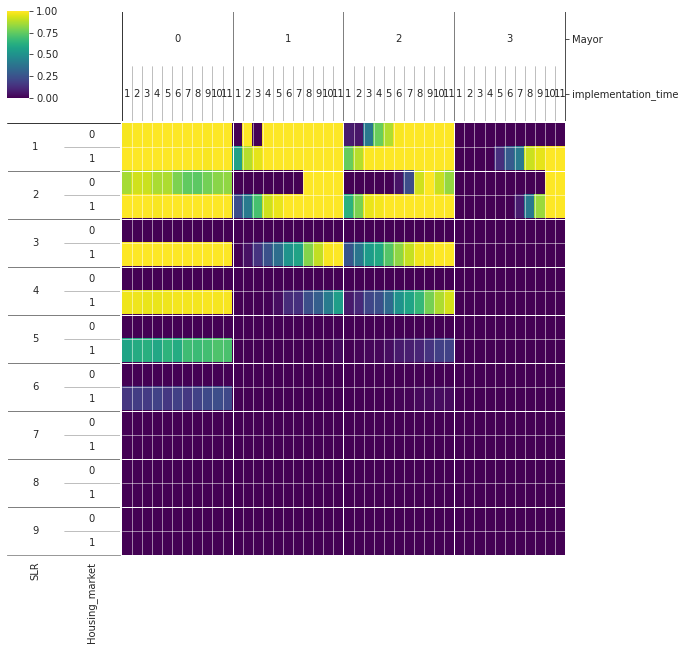

In [79]:
from ema_workbench.analysis import dimensional_stacking

x = experiments3
y = outcomes['CC_first_SETP'] <2200
#y = outcomes['CC_first_SETP'] 

fig = dimensional_stacking.create_pivot_plot(x,y, nr_levels=2, nbins=4,categories=True)

In [83]:
map_mayor
invert_map_mayor = {}

for key,value in map_mayor.items():
    invert_map_mayor[value] = key
invert_map_mayor

{1: 'H. Economicus', 2: 'Sentiment', 0: 'R. Active', 3: 'Lawkeeper'}

In [ ]:
threshold_year = 2200

x = experiments3
y = outcomes['CC_first_SETP'] <threshold_year
#y = outcomes['CC_first_SETP'] 

fig = dimensional_stacking.create_pivot_plot(x,y, nr_levels=2, nbins=4,categories=True)

horizontal_texts = fig._axstack._elements[2][1][1].texts
for i,text in enumerate(horizontal_texts):
    if i % 12 == 0: #it's a mayor text
        text._text = invert_map_mayor[i//12]
        
    else:
            values = [4,5,6,7,8,9,10,11,12,13,14]
            index = int(text._text)-1
            text._text = str(values[index])

vertical_texts = fig._axstack._elements[1][1][1].texts
for i, text in enumerate(vertical_texts):
    if i % 3 == 0: #number can be divided by three
        pass #don't change the SLR labels
    else:
        if text._text == '0': text._text = 'R'
        elif text._text == '1': text._text =  'BR'

In [ ]:
foldername = "Visualisations"

today = datetime.date(datetime.now())
date = "{}_{}_{}".format(today.year,today.month,today.day)

target = Path(foldername,date)

if not Path.exists(target): Path.mkdir(target)

fig.savefig((target / "Dimstack_fivehundred_CC_below_{}.png".format(threshold_year)),bbox_inches="tight",dpi=200)

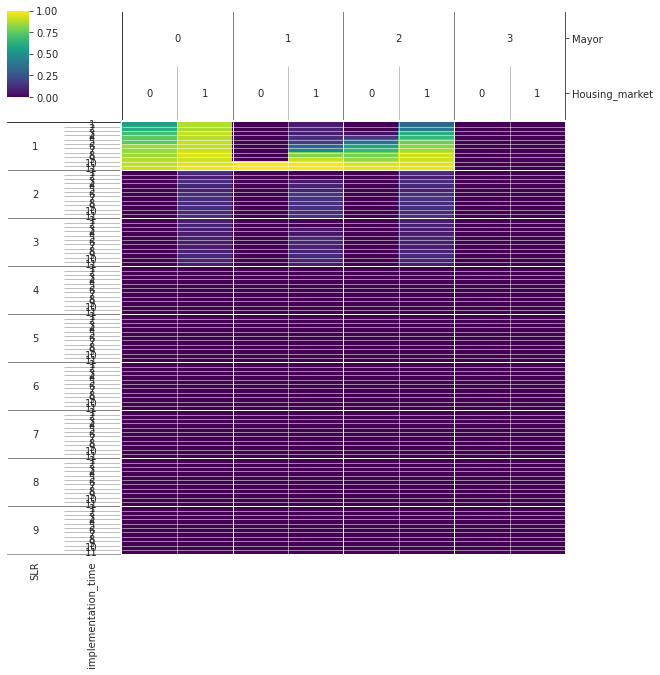

In [126]:
threshold_year = 2090

x = experiments3
y = outcomes['CC_first_SETP'] < threshold_year
#y = outcomes['CC_first_SETP'] 

fig = dimensional_stacking.create_pivot_plot(x,y, nr_levels=2, nbins=4,categories=True)

# horizontal_texts = fig._axstack._elements[2][1][1].texts
# for i,text in enumerate(horizontal_texts):
#     if i % 12 == 0: #it's a mayor text
#         text._text = invert_map_mayor[i//12]
        
#     else:
#             values = [4,5,6,7,8,9,10,11,12,13,14]
#             index = int(text._text)-1
#             text._text = str(values[index])

# vertical_texts = fig._axstack._elements[1][1][1].texts
# for i, text in enumerate(vertical_texts):
#     if i % 3 == 0: #number can be divided by three
#         pass #don't change the SLR labels
#     else:
#         if text._text == '0': text._text = 'R'
#         elif text._text == '1': text._text =  'BR'

### Inspect some values manually

In [153]:
df = pd.DataFrame(outcomes)
df = df.merge(experiments3,left_index=True,right_index=True)
sel = df.loc[(df.Mayor == 1) & (df.SLR==1) & (df.Housing_market == 0) & (df.implementation_time == 5)]
#sel.CC_first_SETP.unique()
sel

,HP_hp_2200,CC_hp_2200,HP_first_SETP,CC_first_SETP,Housing_market,SLR,implementation_time,transient,Mayor
198063,0,340107.108737,2075,2100,0,1,5,410,1
198483,0,340107.108737,2075,2100,0,1,5,342,1
198767,0,340107.108737,2075,2100,0,1,5,22,1
199121,0,340107.108737,2075,2100,0,1,5,348,1
199138,0,340107.108737,2075,2100,0,1,5,130,1
...,...,...,...,...,...,...,...,...,...
295747,0,340107.108737,2075,2100,0,1,5,468,1
296121,0,340107.108737,2075,2100,0,1,5,99,1
296450,0,340107.108737,2075,2100,0,1,5,134,1
296831,0,340107.108737,2075,2100,0,1,5,274,1


### Dimensional stacking: Heijplaat tips before 2100

[MainProcess/INFO] model dropped from analysis because only a single category


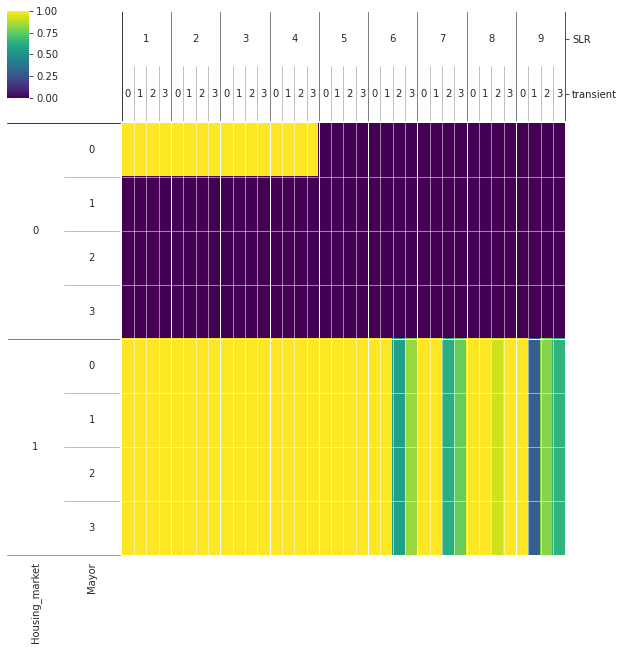

In [35]:
x = experiments2.drop('policy',axis=1)
y = outcomes['HP_first_SETP'] <2100
#y = outcomes['CC_first_SETP'] 

fig = dimensional_stacking.create_pivot_plot(x,y, 2, nbins=4,categories=True)

Interpretation: in a boundedly rational housing market, there will almost certainly be a tipping point before 2100 in the Heijplaat. With a low degree of SLR (scenario 6-9), the city might survive, but this depends on the transient storm surge scenarios.

Note that this does not necessarily mean that in the other scenarios the house price does not go to zero!!!! It just indicates that this does not go ABRUPT, tipping-point like.

In a rational housing market, there will only be tipping points under very high sea level rise scenarios and Mayor 0 (Economicus).

### Parallel coordinate plots

In [38]:
from ema_workbench.analysis import parcoords
data = results.loc[:, [o.name for o in model.outcomes]]

AttributeError: 'tuple' object has no attribute 'loc'

In [51]:
exp_par = experiments.copy().drop(['policy','model','scenario'],axis=1)
exp_par['SLR'] = exp_par['SLR'].astype('float')
exp_par

,Housing_market,SLR,transient,Mayor
0,boundedly_rational,6.0,18.0,H. Economicus
1,rational,6.0,19.0,H. Economicus
2,rational,4.0,12.0,H. Economicus
3,rational,1.0,5.0,H. Economicus
4,rational,2.0,7.0,H. Economicus
...,...,...,...,...
3995,rational,8.0,9.0,Lawkeeper
3996,rational,3.0,5.0,Lawkeeper
3997,boundedly_rational,5.0,13.0,Lawkeeper
3998,boundedly_rational,7.0,1.0,Lawkeeper


In [59]:
limits = parcoords.get_limits(exp_par)
limits

,Housing_market,SLR,transient,Mayor
0,"{boundedly_rational, rational}",1.0,0.0,"{Lawkeeper, Sentiment, R. Active, H. Economicus}"
1,"{boundedly_rational, rational}",9.0,19.0,"{Lawkeeper, Sentiment, R. Active, H. Economicus}"


In [60]:
paraxes = parcoords.ParallelAxes(limits)

AttributeError: 'DataFrame' object has no attribute 'ix'

### Regional sensitivity analysis

In [124]:
experiments2['SLR'] = experiments2['SLR'].astype('float')

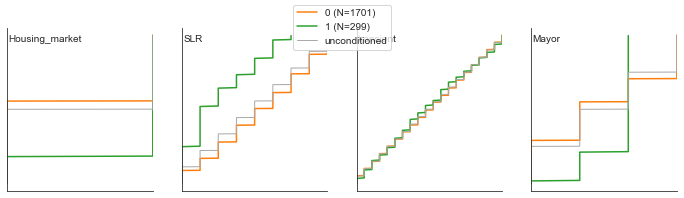

In [125]:
sns.set_style('white')

# model is the same across experiments
x = experiments2.copy()
x = x.drop(['model','policy'], axis=1)
y = outcomes['CC_first_SETP'] <2200
fig = regional_sa.plot_cdfs(x,y)
sns.despine()
plt.show()

# Sobol-indices (does not work)

In [36]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

with MultiprocessingEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=1000, policies=['Sentiment'],
                                               uncertainty_sampling='sobol')

experiments, outcomes = sa_results

[MainProcess/INFO] pool started
[MainProcess/INFO] terminating pool


AttributeError: 'NoneType' object has no attribute 'sample'

In [ ]:
problem = get_SALib_problem(model.uncertainties)
Si = sobol.analyze(problem, outcomes['max_P'],
                   calc_second_order=True, print_to_console=False)

# Old stuff

C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\urban-SETP\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "
[MainProcess/INFO] no time dimension found in results


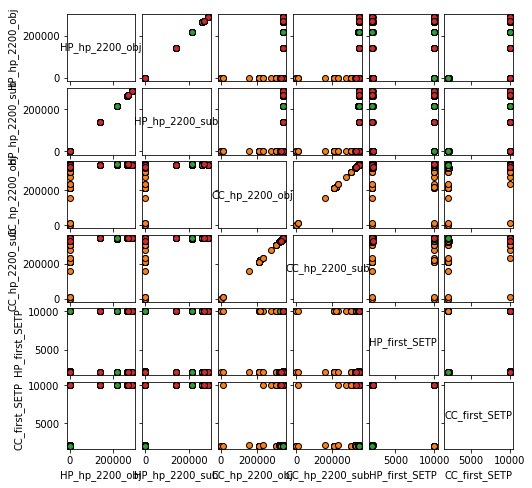

In [7]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, group_by='policy',
                                         legend=False)
fig.set_size_inches(8,8)
plt.show()

In [8]:
from ema_workbench.analysis import feature_scoring

x = pd.DataFrame(experiments)
y = pd.DataFrame(outcomes)

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

TypeError: '<' not supported between instances of 'Reactive' and 'Lawkeeper'

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

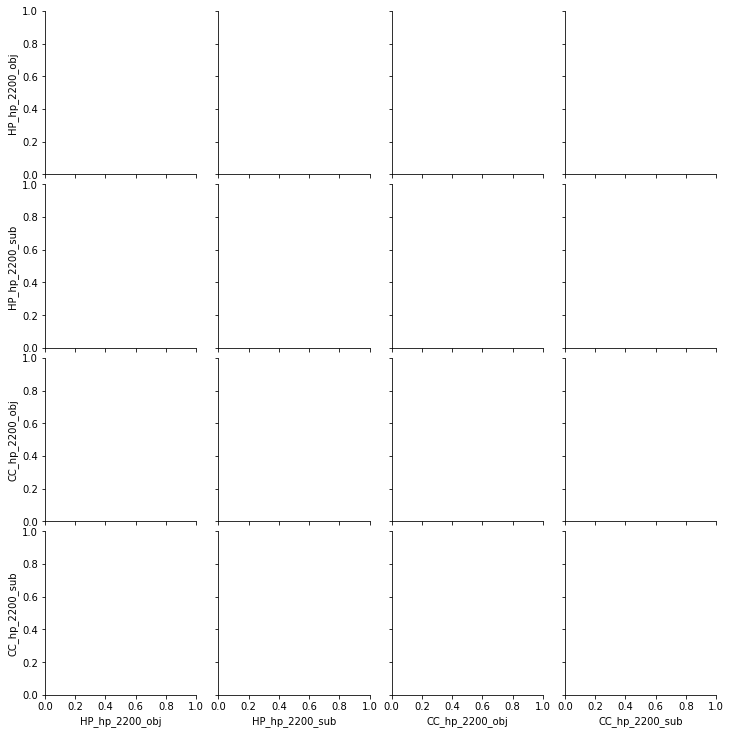

In [21]:
policies = experiments['policy']
for i, policy in enumerate(np.unique(policies)):
    experiments.loc[policies==policy, 'policy'] = str(i)

data = pd.DataFrame(outcomes)
data['policy'] = policies


sns.pairplot(data, hue='policy', vars=list(outcomes.keys()))
plt.show()

In [13]:
experiments.Mayor.unique()

array([<mayors.Reactive object at 0x000001D502353A60>,
       <mayors.Lawkeeper object at 0x000001D502353E80>], dtype=object)

In [14]:
experiments2 = experiments.copy()
experiments2['SLR']=  experiments2['RCP'] + "_" + experiments2['collapse'].map(str) + "_"  + experiments2['PDF'].map(str)
experiments2

KeyError: 'RCP'

In [92]:
slr_scenarios = experiments2['SLR']
#unique = np.unique(slr_scenarios)
#for i, slr in enumerate(unique):
#     experiments2.loc[slr_scenarios==slr, 'SLR'] = str(i) #replace  by integer
data = pd.DataFrame(outcomes)
data['slr_scenarios'] = slr_scenarios
#data['slr_scenarios']
data.iloc[:,4]

0        RCP85_True_50
1        RCP85_True_17
2       RCP26_False_17
3       RCP26_False_17
4        RCP85_True_17
             ...      
3995     RCP26_True_17
3996    RCP26_False_50
3997    RCP26_False_17
3998    RCP85_False_50
3999     RCP26_True_50
Name: slr_scenarios, Length: 4000, dtype: object

In [98]:
data.sort_values(by='slr_scenarios',inplace=True)

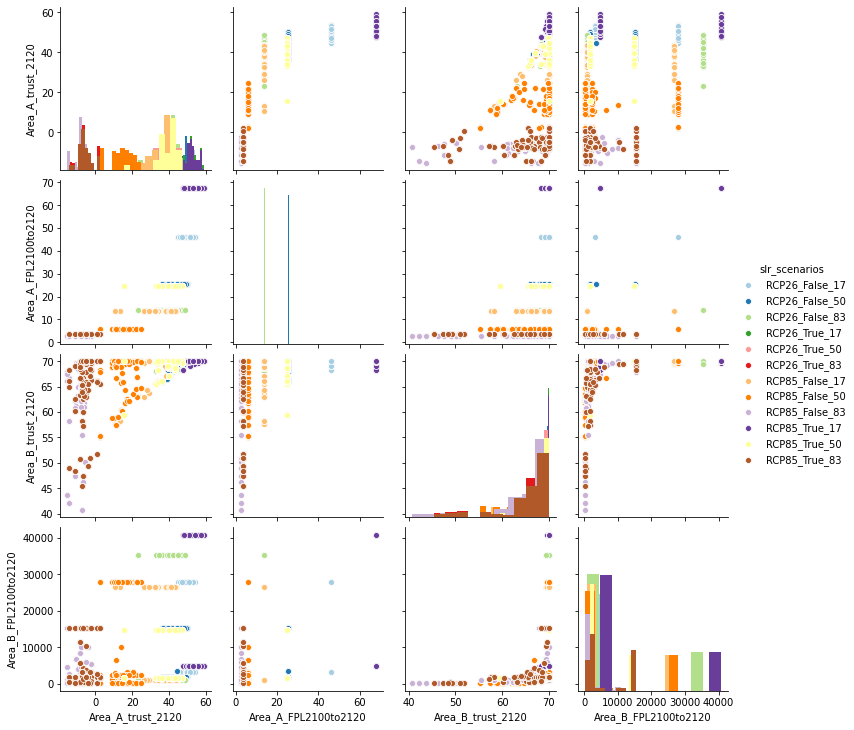

In [104]:
sns.pairplot(data, hue='slr_scenarios',vars=list(outcomes.keys()),diag_kind='hist',palette='Paired')

In [ ]:
for i, policy in enumerate(np.unique(policies)):
    experiments.loc[policies==policy, 'policy'] = str(i)

data = pd.DataFrame(outcomes)
data['policy'] = policies


sns.pairplot(data, hue='policy', vars=list(outcomes.keys()))
plt.show()

[MainProcess/INFO] no time dimension found in results


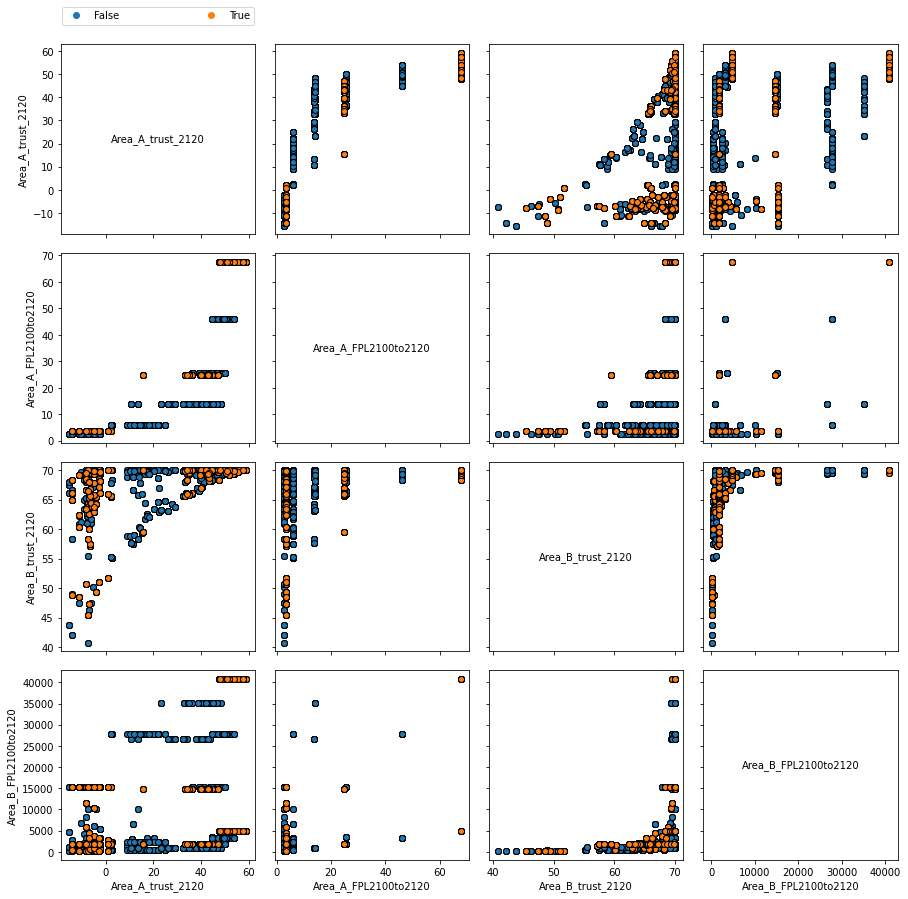

In [28]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, group_by='collapse',
                                         legend=True)
fig.set_size_inches(15,15)
plt.show()

In [22]:
outcomes

{'Area_A_trust_2120': array([45.08716481, 55.53645285, 51.64224843, ..., 53.90578306,
        11.96904438, 34.07296084]),
 'Area_A_FPL2100to2120': array([24.76569913, 67.62419361, 46.17610852, ..., 46.17610852,
         5.92469669, 24.76569913]),
 'Area_B_trust_2120': array([69.92675009, 69.64431336, 69.1611392 , ..., 69.45103983,
        69.81192545, 65.99996165]),
 'Area_B_FPL2100to2120': array([1741.85920216, 4818.09541286, 3278.66657571, ..., 3278.66657571,
        2403.91616273, 1741.85920216])}

In [26]:
from ema_workbench.analysis import feature_scoring
x = experiments
y = outcomes



AttributeError: module 'ema_workbench.analysis.feature_scoring' has no attribute 'CLASSIFICATION'